In [1]:
# 1 import package
import torch
import  torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.utils import save_image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from scipy import linalg as la
import numpy as np
import math

/home/waj/anaconda3/envs/tts/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
BATCH_SIZE=256
EPOCHS=200
image_size=32
channel=1
z_dim=128
n_flow=30
n_block=4
n_channel=1
n_sampls=25
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [3]:
class Jitter:
    """Transform for dataloader, adds uniform jitter noise to data"""

    def __init__(self, scale=1.0 / 256):
        """Constructor

        Args:
          scale: Scaling factor for noise
        """
        self.scale = scale

    def __call__(self, x):
        eps = torch.rand_like(x) * self.scale
        x_ = x + eps
        return x_
    
class Scale:
    """Transform for dataloader, adds uniform jitter noise to data"""

    def __init__(self, scale=255.0 / 256.0):
        """Constructor

        Args:
          scale: Scaling factor for noise
        """
        self.scale = scale

    def __call__(self, x):
        return x * self.scale

In [4]:
def show_mnist_image(image_array, label):
    plt.imshow(image_array, cmap='Greys')
    plt.title(f"Label: {label}")
# 1 data loader 
dataset=datasets.MNIST("../data/",train=True,transform=transforms.Compose([
    transforms.Resize(32),transforms.ToTensor()
]))
mnist=DataLoader(dataset,shuffle=True,batch_size=BATCH_SIZE,drop_last=True)

torch.Size([256, 1, 32, 32])


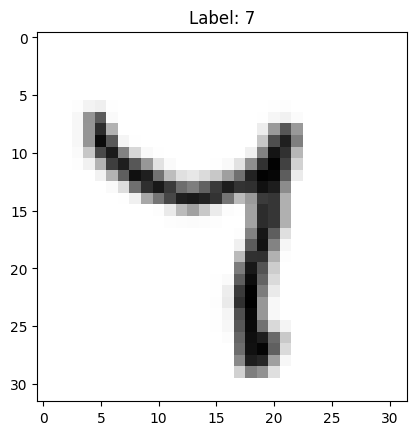

In [5]:
for data in mnist:
    print(data[0].shape)
    show_mnist_image(data[0][0][0], data[1][0])
    break

In [6]:
def calc_z_shapes(n_channel,input_size,n_flow,n_block):
    z_shapes=[]
    for i in range(n_block-1):
        input_size//=2
        n_channel*=2
        z_shapes.append((n_channel,input_size,input_size))
    input_size//=2
    z_shapes.append((n_channel*4,input_size,input_size))
    return z_shapes

In [7]:
z_shapes=calc_z_shapes(n_channel,image_size,n_flow,n_block)
z_shapes

[(2, 16, 16), (4, 8, 8), (8, 4, 4), (32, 2, 2)]

In [8]:
z_samples=[]
for z in z_shapes:
    z_new=torch.randn(n_sampls,*z)
    z_samples.append(z_new)
[print(x.shape) for x in z_samples]

torch.Size([25, 2, 16, 16])
torch.Size([25, 4, 8, 8])
torch.Size([25, 8, 4, 4])
torch.Size([25, 32, 2, 2])


[None, None, None, None]

# 模型定义

![架构图](./architecture.png)

In [9]:
logabs=lambda x : torch.log(torch.abs(x))
class Actnorm(nn.Module):
    def __init__(self,in_channel,logdet=True):
        super(Actnorm,self).__init__()
        self.bias=nn.Parameter(torch.zeros(1,in_channel,1,1))
        self.scale=nn.Parameter(torch.ones(1,in_channel,1,1))
        self.register_buffer("initialized",torch.tensor(0))
        self.logdet=logdet
    
    # 求出channel维度的均值和方差作为初始值
    def initialize(self,input):
        with torch.no_grad():
            flatten=input.permute(1,0,2,3).contiguous().view(input.shape[1],-1)
            mean=flatten.mean(1).unsqueeze(1).unsqueeze(2).unsqueeze(3).permute(1,0,2,3)
            std=flatten.std(1).unsqueeze(1).unsqueeze(2).unsqueeze(3).permute(1,0,2,3)
            self.bias.data.copy_(-mean)
            self.scale.data.copy_(1/(std+1e-6)) # 防止数据下益
    def forward(self,input):
        bs,channel,height,width=input.shape
        if self.initialized.item()==0:
            self.initialize(input)
            self.initialized.fill_(1)
        
        y=(input+self.bias)*self.scale
        
        if self.logdet:
            logdet=height*width*torch.sum(logabs(self.scale))
            return y,logdet
        else :
            return y
        
    def reverse(self,input):
        return (input-self.bias)/self.scale

        

In [10]:
actorn=Actnorm(1)
x=torch.randn(3,1,28,28)
x,logdet=actorn(x)
print(x.shape,logdet)

torch.Size([3, 1, 28, 28]) tensor(1.9927, grad_fn=<MulBackward0>)


![架构图](./table3.png)

In [11]:
class InvConv2d(nn.Module):
    def __init__(self,in_channel):
        super(InvConv2d,self).__init__()
        self.weight=nn.Parameter(torch.randn(in_channel,in_channel,1,1))
    def forward(self,input):
        bs,channel,height,width=input.shape
        out=nn.functional.conv2d(input,self.weight)
        logdet=height*width*torch.slogdet(self.weight.double())[1].float()
        return out ,logdet
    def reverse(self,input):
        out=nn.functional.conv2d(input,self.weight.inverse().unsqueeze().unsqueeze(3))
        return out


In [12]:
weight=np.random.randn(3,3)
q,d=la.qr(weight)
print(sum(q[1,:]*q[:,1]))
q,d

0.46189072469327913


(array([[-0.81428037,  0.48849559,  0.31355946],
        [-0.53774939, -0.83822175, -0.09060846],
        [ 0.21857053, -0.2423971 ,  0.94523572]]),
 array([[-1.46753404, -2.05675499, -0.6560951 ],
        [ 0.        ,  0.25772116, -0.73058326],
        [ 0.        ,  0.        ,  1.58161801]]))

In [13]:
p,l,u=la.lu(q)
print(u)
np.diag(u)

[[-0.81428037  0.48849559  0.31355946]
 [ 0.         -1.16082342 -0.2976826 ]
 [ 0.          0.          1.05793717]]


array([-0.81428037, -1.16082342,  1.05793717])

In [14]:
np.triu(u,1)

array([[ 0.        ,  0.48849559,  0.31355946],
       [ 0.        ,  0.        , -0.2976826 ],
       [ 0.        ,  0.        ,  0.        ]])

In [15]:
np.triu(np.ones_like(u),1)

array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [16]:
r_weight=np.random.randn(3,3)
q,r=la.qr(r_weight)
p,l,u=la.lu(q.astype(np.float32))
s=np.diag(u)
u=np.triu(u,1)

u_mask=np.triu(np.ones_like(u),1)
l_mask=u_mask.T
l_eye=np.eye(l_mask.shape[0])
# weight=p@(l*l_mask+l_eye)@(u*u_mask+torch.diag(s_sign*torch.exp(s)))

p

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [17]:
l*l_mask+l_eye
print(u*u_mask,np.exp(s))
u*u_mask+np.diag(np.exp(s))
np.diag(np.exp(s)).shape

[[ 0.         -0.21139191 -0.47241664]
 [ 0.          0.          0.27314025]
 [ 0.          0.          0.        ]] [0.42500708 0.38102576 3.3576167 ]


(3, 3)

In [18]:
class InvConv2d_lu(nn.Module):
    def __init__(self,in_channel):
        super(InvConv2d_lu,self).__init__()
        weight=np.random.randn(in_channel,in_channel)
        q,r=la.qr(weight)
        p,l,u=la.lu(q.astype(np.float32))
        s=np.diag(u)
        u=np.triu(u,1)
        u_mask=np.triu(np.ones_like(u),1)
        l_mask=u_mask.T
        
        p=torch.from_numpy(p)
        l=torch.from_numpy(l)
        s=torch.from_numpy(s)
        u=torch.from_numpy(u)
        u_mask=torch.from_numpy(u_mask)
        l_mask=torch.from_numpy(l_mask)
        
        self.register_buffer("p",p)
        self.register_buffer("u_mask",u_mask)
        self.register_buffer("l_mask",l_mask)
        self.register_buffer("s_sign",torch.sign(s))
        self.register_buffer("l_eye",torch.eye(l_mask.shape[0]))
        self.l=nn.Parameter(l)
        self.s=nn.Parameter(logabs(s))
        self.u=nn.Parameter(u)
        
    def calc_weight(self):
        
        weight=self.p@(self.l*self.l_mask+self.l_eye)@ \
        (self.u*self.u_mask+torch.diag(self.s_sign*torch.exp(self.s)))
        return weight.unsqueeze(2).unsqueeze(3)
    
    def forward(self,input):
        bs,channel,height,width=input.shape
        weight=self.calc_weight()
        out=nn.functional.conv2d(input,weight)
        logdet=height*width*torch.sum(self.s)
        return out ,logdet
    
    def reverse(self,input):
        weight=self.calc_weight()
        out=nn.functional.conv2d(input,weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)) 
        return out


In [19]:
invConv_lu=InvConv2d_lu(1)

x,logdet=invConv_lu(x)
print(x.shape,logdet)

torch.Size([3, 1, 28, 28]) tensor(0., grad_fn=<MulBackward0>)


/tmp/ipykernel_56041/2649664392.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  s=torch.from_numpy(s)


In [20]:
invConv_lu.u_mask

tensor([[0.]])

![架构图](./table3.png)

In [21]:
class ZeroConv2d(nn.Module):
    def __init__(self,in_channel,out_channel,padding=1):
        super().__init__()
        self.conv=nn.Conv2d(in_channel,out_channel,3,padding)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale=nn.Parameter(torch.zeros(1,out_channel,1,1))
    def forward(self,input):
        out=nn.functional.pad(input,[1,1,1,1],value=1)
        out=self.conv(out)
        out=out*torch.exp(self.scale*3)
        return out

In [22]:
zeroConv=ZeroConv2d(1,10)
zeroConv(x).shape

torch.Size([3, 10, 28, 28])

In [23]:
class AffineCoupling(nn.Module):
    def __init__(self,in_channel,filter_size=512,affine=True):
        super(AffineCoupling,self).__init__()
        self.affine=affine
        self.net=nn.Sequential(
        nn.Conv2d(in_channel//2,filter_size,3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(filter_size,filter_size,1),
        nn.ReLU(inplace=True),
        ZeroConv2d(filter_size,in_channel if self.affine else in_channel//2)
        )
        
        self.net[0].weight.data.normal_(0,0.05)
        self.net[0].bias.data.zero_()
        self.net[2].weight.data.normal_(0,0.05)
        self.net[2].bias.data.zero_()     
    def forward(self,input):
        in_a,in_b=input.chunk(2,1)
        if self.affine:
            logs,t=self.net(in_b).chunk(2,1)
            y_a=torch.exp(logs)*in_a+t
            y_b=in_b
            logdet=torch.sum(logabs(torch.exp(logs)))
        else:
            y_b=in_b
            y_a=in_a+self.net(in_b)
            logdet=None
#         return y_a,y_b
        return torch.cat([y_a,y_b],1),logdet
    def reverse(self,output):
        y_a,y_b=output.chunk(2,1)
        if self.affine:
            in_b=y_b
            logs,t=self.net(in_b).chunk(2, 1)
            in_a=(y_a-t)/torch.exp(logs)
        else :
            in_b=y_b
            in_a=self.net(in_b)-y_a
        return torch.cat([in_a,in_b],1)   

In [24]:
affCoup=AffineCoupling(4)
a,b=affCoup(torch.randn(3,4,28,28))

a.shape,b

(torch.Size([3, 4, 28, 28]), tensor(0., grad_fn=<SumBackward0>))

In [25]:
torch.diag(torch.randn(2,2))

tensor([-2.2581, -0.6020])

In [26]:
        
class Flow(nn.Module):
    def __init__(self,in_channel,affine=True,conv_lu=True):
        super(Flow,self).__init__()
        self.actorm=Actnorm(in_channel)
        if conv_lu:
            self.invConv2d=InvConv2d_lu(in_channel)
        else:
            self.invConv2d=InvConv2d(in_channel)
        self.coupling=AffineCoupling(in_channel,256)
    def forward(self,input):
        out,det1=self.actorm(input)
        out,det2=self.invConv2d(out)
        out,det3=self.coupling(out)
        logdet=det1+det2
        if det3 is not None:
            logdet+=det3
        return out,logdet
    
    def reverse(self,output):
        input_=self.coupling.reverse(output)
        input_=self.invConv2d.reverse(input_)
        input_=self.actorm.reverse(input_)
        return input_
    
        

In [27]:
flow=Flow(4)
a,b=flow(torch.randn(3,4,14,14))
a.shape,b

(torch.Size([3, 4, 14, 14]), tensor(1.2851, grad_fn=<AddBackward0>))

![架构图](./architecture.png)

In [28]:
def gaussian_log_p(x,mean,log_std):
    return -0.5*math.log(2* math.pi)-log_std-0.5*(x-mean)**2/torch.exp(2*log_std)


def gaussian_sample(eps,mean,log_std):
    return mean+torch.exp(log_std)*eps

In [29]:
class Block(nn.Module):
    def __init__(self,in_channel,n_flow,split=True,affine=True,conv_lu=True):
        super().__init__()
        squeeze_dim=in_channel*4
        self.flows=nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim,affine=affine,conv_lu=conv_lu))
        self.split=split
        
        if split:
            self.prior=ZeroConv2d(in_channel*2,in_channel*4)
        else: 
            self.prior=ZeroConv2d(in_channel*4,in_channel*8)
        
    def forward(self,input):
        bs,n_channel,height,width=input.shape
        squeezed=input.view(bs,n_channel,height//2,2,width//2,2)
        squeezed=squeezed.permute(0,1,3,5,2,4)
        out=squeezed.contiguous().view(bs,n_channel*4,height//2,width//2)
        logdet=0

        for flow in self.flows:
            out,det=flow(out)
            logdet+=det
        
        if self.split:
            out,z_new=out.chunk(2,1)
            mean,logstd=self.prior(out).chunk(2,1)
            log_p=gaussian_log_p(out,mean,logstd)
            log_p=log_p.view(bs,-1).sum(1)
            
        else:
            zero=torch.zeros_like(out)
            mean,logstd=self.prior(zero).chunk(2,1)
            log_p=gaussian_log_p(out,mean,logstd)
            log_p=log_p.view(bs,-1).sum(1)
            z_new=out
        return out,logdet,log_p,z_new
    
    def reverse(self,output,eps=None,reconstruct=False):
        input=output
        
        if reconstruct:
            if self.split:
                input=torch.cat([output,eps],1)
            else:
                input=eps
        else:
            if self.split:
                mean,logstd=self.prior(input).chunk(2,1)
                z=gaussian_sample(eps,mean,logstd)
                input=torch.cat([output,z],1)
                
            else:
                zero=torch.zeros_like(input)
                mean,logstd=self.prior(zero).chunk(2,1)
                z=gaussian_sample(eps,mean,logstd)
                input=z
        for flow in self.flows[::-1]:
            input=flow.reverse(input)
            
        bs,n_channel,height,width=input.shape
        unsqueezed=input.view(bs,n_channel//4,2,2,height,width)
        unsqueezed=unsqueezed.permute(0,1,4,2,5,3)
        unsqueezed=unsqueezed.contiguous().view(bs,n_channel//4,height*2,width*2)
        
        return unsqueezed
  

In [30]:
block=Block(1,2)
out,logdet,log_p,z_new=block(torch.randn(3,1,28,28))
out.shape,logdet,log_p,z_new.shape

(torch.Size([3, 2, 14, 14]),
 tensor(7.0470, grad_fn=<AddBackward0>),
 tensor([-546.8235, -548.6953, -573.1659], grad_fn=<SumBackward1>),
 torch.Size([3, 2, 14, 14]))

In [31]:
prior=ZeroConv2d(1*2,1*4)
prior(torch.zeros(1,2,3,4))

tensor([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]], grad_fn=<MulBackward0>)

In [32]:
class Glow(nn.Module):
    def __init__(self,in_channel,n_flow,n_block,affine=True,conv_lu=True):
        super().__init__()
        self.blocks=nn.ModuleList()
        n_channel=in_channel
        for i in range(n_block-1):
            self.blocks.append(Block(n_channel,n_flow,affine,conv_lu))
            n_channel*=2
        self.blocks.append(Block(n_channel,n_flow,split=False,affine=affine))
        
    def forward(self,input):
        log_p_sum=0
        logdet=0
        out=input
        z_outs=[]
        for block in self.blocks:
            out,det,log_p,z_new=block(out)
            z_outs.append(z_new)
            logdet=logdet+det
            
            if log_p is not None:
                log_p_sum=log_p_sum+log_p
        return log_p_sum,logdet,z_outs
    
    def reverse(self,z_list,reconstruct=False):
        for i,block in enumerate(self.blocks[::-1]):
            if i ==0:
                input=block.reverse(z_list[-1],z_list[-1],reconstruct=reconstruct)
                
            else:
                input=block.reverse(input,z_list[-(i+1)],reconstruct=reconstruct)
        return input

In [33]:
glow=Glow(n_channel,n_flow,n_block)
log_p_sum,logdet,z_outs = glow(data[0])
log_p_sum.shape,logdet,[z.shape for z in z_outs]

(torch.Size([256]),
 tensor(2141.1357, grad_fn=<AddBackward0>),
 [torch.Size([256, 2, 16, 16]),
  torch.Size([256, 4, 8, 8]),
  torch.Size([256, 8, 4, 4]),
  torch.Size([256, 32, 2, 2])])

In [34]:
glow.reverse(z_samples).shape

torch.Size([25, 1, 32, 32])

# 优化器

In [35]:
glow=Glow(n_channel,n_flow,n_block)
glow.to(device)
optimizer=torch.optim.Adam(glow.parameters(),1e-5)

# 损失函数计算

In [36]:
def calc_loss(logp,logdet,imagesize):
    n_pixel = image_size * image_size * 1
    loss=logdet+logp
    return -loss.mean()/n_pixel,logp.mean()/n_pixel,logdet.mean()/n_pixel

In [37]:
def calc_z_shapes(n_channel,input_size,n_flow,n_block):
    z_shapes=[]
    for i in range(n_block-1):
        input_size//=2
        n_channel*=2
        z_shapes.append((n_channel,input_size,input_size))
    input_size//=2
    z_shapes.append((n_channel*4,input_size,input_size))
    return z_shapes

In [ ]:
n_bits=5
n_bins = 2.0 ** n_bits
z_sample=[]
z_shapes=calc_z_shapes(1,image_size,n_flow,n_block)
for z in z_shapes:
    z_new=torch.randn(n_sampls,*z)
    z_sample.append(z_new.to(device))
index=0
EPOCHS=400
for epoch in range(EPOCHS):
    for data,label in mnist:
        x=data.to(device)
        x = x * 255
        x = torch.floor(x / 2 ** (8 - n_bits))
        x = x / n_bins - 0.5
       
        if index==0:
            with torch.no_grad():
                log_p,logdet,_=glow(x+ torch.rand_like(x) / n_bins)
                index+=1
                continue
        else:
            log_p,logdet,_=glow(x+torch.rand_like(x) / n_bins)
            index+=1
        logdet=logdet.mean()
        
        loss,log_p,log_det=calc_loss(log_p,logdet,image_size)
        glow.zero_grad()
        loss.backward()
        optimizer.step()
      
        if index%50==0:
            print(f"epoch {epoch} index : {index}, loss {loss} , logdet :{log_det}")
            with torch.no_grad():
        
                save_image(
                glow.reverse(z_sample).cpu().data,
                    f"sample/{ str(index).zfill(6)}.png",
                    normalize=True,
                    nrow=5,
                    range=(-0.5, 0.5),
                
                )